# Model Selection

## Import libraries and datasets

In [24]:
# Import libraries
import pandas as pd # For placing the data into dataframes for analysis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools as itl
import sklearn
import pickle
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, make_scorer, plot_roc_curve, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


# Fix display settings for viewing output
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_rows', 400)

In [2]:
# Import training datasets
X_train = pd.read_csv("../datasets/X_train.csv")
y_train = pd.read_csv("../datasets/y_train.csv")
# X_val = pd.read_csv("../datasets/X_val.csv")
# y_val = pd.read_csv("../datasets/y_val.csv")

In [3]:
# Check on imported X train
X_train.head()

,loan_amnt,term,int_rate,inq_last_6mths,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,percent_bc_gt_75,tot_hi_cred_lim,total_dti_consol,sub_grade_d,fico_median,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,28000.0,60.0,10.78,1.0,3.0,8.0,31708.0,253.0,6.0,5.0,6.0,4.0,16.7,426839.0,22.72,24,767.0,1,0,0,0,0,0
1,5000.0,36.0,7.62,0.0,0.0,2.0,7483.0,341.0,6.0,5.0,69.0,3.0,0.0,319093.0,14.13,13,717.0,1,0,0,0,0,1
2,15000.0,36.0,7.89,0.0,0.0,4.0,7260.0,175.0,7.0,1.0,25.0,4.0,25.0,316999.0,6.55,15,707.0,1,0,0,0,0,0
3,15000.0,36.0,12.74,0.0,2.0,4.0,4647.0,380.0,11.0,1.0,20.0,5.0,33.3,68940.0,23.11,31,697.0,1,0,0,0,1,0
4,20000.0,36.0,8.39,0.0,0.0,0.0,294.0,233.0,30.0,5.0,92.0,13.0,100.0,24700.0,8.54,15,672.0,1,0,0,0,0,1


In [4]:
# Check datatype of X_train
X_train.dtypes

loan_amnt                              float64
term                                   float64
int_rate                               float64
inq_last_6mths                         float64
inq_last_12m                           float64
acc_open_past_24mths                   float64
bc_open_to_buy                         float64
mo_sin_old_rev_tl_op                   float64
mo_sin_rcnt_tl                         float64
mort_acc                               float64
mths_since_recent_bc                   float64
num_rev_tl_bal_gt_0                    float64
percent_bc_gt_75                       float64
tot_hi_cred_lim                        float64
total_dti_consol                       float64
sub_grade_d                              int64
fico_median                            float64
home_ownership_MORTGAGE                  int64
home_ownership_NONE                      int64
home_ownership_OWN                       int64
home_ownership_RENT                      int64
verification_

In [5]:
# Check shape of X_train data
X_train.shape

(713403, 23)

In [6]:
# Check on imported y train
y_train.head()

,loan_status
0,1
1,0
2,0
3,0
4,0


In [7]:
# Check datatype of y_train
y_train.dtypes

loan_status    int64
dtype: object

In [8]:
# Convert to an array for model
y_train = np.ravel(y_train)

In [9]:
# Check shape of y_train data
y_train.shape

(713403,)

### Scale features

In [11]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
# X_val_sc = ss.transform(X_val)

### Class Weights

Based on the EDA done in the previous notebook, it can be seen from the data, that there are more 'Paid Off' loans than 'Defaulted/Charged off' ones. In order to get a better balance in the model, a class ratio will be used for class weights

In [14]:
# Get class weight of the loan status
cw = y_train.sum()/y_train.shape
cw

array([0.20770028])

### Baseline - Logistic Regression

AUC score for training baseline mode is 0.72


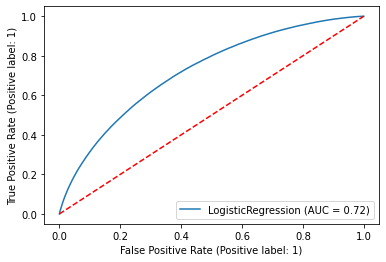

In [28]:
# Instantiate Logistic Regression Classifier
lr = LogisticRegression(class_weight = 'balanced', random_state = 1)

# setting the number of folds
kf = KFold(5)

# Fit Logistic Regression Classifier and compute prediction
base_pred_train = cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'roc_auc')
base_pred_auc = round((base_pred_train.mean()), 3)

# Show AUC score of baseline model
print('AUC score for training baseline mode is ' + str(base_pred_auc))

# Plot ROC AUC curve
lr.fit(X_train_sc, y_train)
plot_roc_curve(lr, X_train_sc, y_train)
plt.plot([0, 1], [0, 1],'r--')
plt.show;

In [39]:
# Sample of training data using the train test split
X_nil, X_train_ss, y_nil, y_train_ss = train_test_split(X_train, y_train, test_size=.01, random_state=42, stratify=y_train)

In [41]:
print(X_train_ss.shape)
print(y_train_ss.shape)

(7135, 23)
(7135,)


In [42]:
# Initializing Classifiers
clf1 = SGDClassifier(loss = 'log',
                     penalty = 'elasticnet',
                     class_weight = 'balanced',
                     n_jobs = -1,
                     random_state=1)

clf2 = RandomForestClassifier(class_weight = 'balanced', random_state=1)

clf3 = xgb(verbosity = 0, scale_pos_weight=80, random_state=1)

# Building the pipelines
pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', clf1)])

# Setting up the parameter grids
param_grid1 = [{'clf1__l1_ratio': [0, 0.5, 1],
                'clf1__alpha': [0.01, 1, 10]}]

param_grid2 = [{'class_weight': ['balanced'],
                'n_estimators': [50, 100, 200],
                'criterion': ['gini', 'entropy']}]

param_grid3 = [{'clf4__min_child_weight': [1, 5, 10],
                'clf4__gamma': [0.5, 1, 2],
                'clf4__subsample': [0.6, 1.0],
                'clf4__colsample_bytree': [0.6, 1.0],
                'clf4__max_depth': [3, 5]}]

# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                            (pipe1, clf2, clf3),
                            ('SGD-log', 'RandForest', 'XG Boost')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='roc_auc',
                       n_jobs=1,
                       cv=2,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [ ]:
%%time
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train_ss, 
                                   y=y_train_ss, 
                                   cv=outer_cv,
                                   n_jobs=1)
    print('%s | AUC %.4f' %
#     print('%s | outer AUC %.2f%% +/- %.2f' %
          (name, nested_score.mean()))

RandForest | AUC 0.7086
SGD-log | AUC 0.7239


/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/garethloh/anaconda3/envs/cap/lib/python3.8/si

In [36]:
# Import validation datasets
X_val = pd.read_csv("../datasets/X_val.csv")
y_val = pd.read_csv("../datasets/y_val.csv")

In [ ]:
# Fitting a model to the whole training set
# using the "best" algorithm
best_algo = gridcvs['SVM']

best_algo.fit(X_train, y_train)
train_acc = roc_auc_score(y_true=y_train, y_pred=best_algo.predict(X_train))
test_acc = roc_auc_score(y_true=y_test, y_pred=best_algo.predict(X_test))

print('Accuracy %.2f%% (average over CV test folds)' %
      (100 * best_algo.best_score_))
print('Best Parameters: %s' % gridcvs['SVM'].best_params_)
print('Training Accuracy: %.2f%%' % (100 * train_acc))
print('Test Accuracy: %.2f%%' % (100 * test_acc))



RandForest | AUC 0.72  

SGD-log | AUC 0.72

In [18]:
base_pred_train

array([0.66696337, 0.66645874, 0.66961964, 0.66940706, 0.66918279])

In [ ]:

# Fit Logistic Regression Classifier and compute prediction
base_pred_train = cross_val_score(lr, X_train_sm, y_train_sm, cv=kf)

In [ ]:
auc_score = make_scorer(roc_auc_score)

In [ ]:
base_pred_train_reg = cross_val_score(lr, X_train, y_train, cv=kf, scoring = 'roc_auc')

In [ ]:
base_pred_train_reg.mean()

In [ ]:
base_pred_train_reg

In [ ]:
base_pred_train_reg.

In [ ]:
base_pred_train.mean()

In [ ]:
base_pred_train

In [ ]:
# calcluate the AUROC for the training set
base_train_roc = roc_auc_score(y_train_sm, base_pred_train[:,1])
print('For the training set the AUROC is:' + str(base_train_roc)+ '\n' )

In [ ]:
# predicting results on validation set
base_pred_val = lr.predict_proba(X_val_sc)

In [ ]:
# calculate the AUROC for the validation set
base_test_roc = roc_auc_score(y_val, base_pred_val[:,1])
print('For the hold-out set the AUROC is:' + str(base_test_roc))

In [ ]:
# function to display confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    '''Function to display confusion matrix from sickit learn
    documentation'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itl.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)

In [ ]:
%%time
# Compute confusion matrix
cnf_matrix= confusion_matrix(y_val, lr.predict(X_val_sc))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

# Plot hold out set confusion matrix
plt.figure(figsize = (9,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Baseline Confusion matrix ')

## Gridsearch fit and test models

In [ ]:
def classification_model(model, param_grid, score = 'roc_auc'):
    
    # setting the number of folds
    kf = KFold(10, random_state=1)
    
    # Instantiate the GridSearchCV object: cv
    model_cv = GridSearchCV(model, param_grid, cv = kf, scoring = score, 
                            return_train_score = True, n_jobs = -3)
    
    # Fitting the training set 
    model_cv.fit(X_train_sm.astype(float), y_train_sm.astype(float))
        
    # Predict the labels of the test set: y_pred        
    y_pred = model_cv.predict_proba(X_val_sc.astype(float))[:,1]
    
    # Printing best parametrs
    print("Tuned Model Parameters: {}".format(model_cv.best_params_))
    
     # Printing the corresponding AUROC "
    test_roc = roc_auc_score(y_val, y_pred)
    print('The hold-out set AUROC = ' + str(test_roc))
    
    # Compute confusion matrix
    cnf_matrix= confusion_matrix(y_val, model_cv.predict(X_val_sc.astype(float)))
    class_names = ['Charged Off', "Fully Paid"]
    np.set_printoptions(precision=2)

    # Plot hold out set confusion matrix
    plt.figure(figsize = (9,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Hold-out set Confusion matrix ')
    
    return pd.DataFrame(model_cv.cv_results_)

### K Nearest Neighbours

In [ ]:
# K Nearest Neighbours model hyperparameter tuning
knn = KNeighborsClassifier()# Instantiate K Nearest Neighbours model
params = {
    'n_neighbors': range(8,12),
    'weights':['uniform'],
    'leaf_size': range(28, 32),
     'algorithm': ['auto'] # Set params for gridsearch
    }
gs_knn = GridSearchCV(knn, param_grid = params, scoring='balanced_accuracy', verbose=1, return_train_score=True)
gs_knn.fit(X_train_sc, y_train)

In [ ]:
# cross_val_score(knn, X_train_sc, y_train, cv=10).mean()

In [ ]:
# knn.fit(X_val_sc, y_val)

In [ ]:
# cross_val_score(knn, X_val_sc, y_val, cv=10).mean()

### AdaBoost

In [ ]:
ada = AdaBoostClassifier()
pipe_params_ada = {
                'learning_rate': [0.9, 1.0],
                'n_estimators': [30, 50],
                'random_state': [42]
                }
# gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='roc_auc', cv=5, return_train_score= True, n_jobs = -1, verbose=1)
gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_ada.fit(X_train_sc, y_train)
print(gs_ada.best_score_)
gs_ada.best_params_

In [ ]:
ada = AdaBoostClassifier()
pipe_params_ada = {
                'learning_rate': [1.2, 1.6],
                'n_estimators': [60, 80],
                'random_state': [42]
                }
# gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='roc_auc', cv=5, return_train_score= True, n_jobs = -1, verbose=1)
gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_ada.fit(X_train_sc, y_train)
print(gs_ada.best_score_)
gs_ada.best_params_

### Gradient Boost

In [ ]:
gbc = GradientBoostingClassifier()
pipe_params_gbc = {
                'learning_rate': [0.3,0.5],
                'max_depth': [2,3],
                'min_samples_leaf': [1,2],
                'n_estimators': [50,100],
                'random_state': [42],
                'max_features': ['auto']
                }
gs_gbc = GridSearchCV(gbc, param_grid=pipe_params_gbc, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_gbc.fit(X_train_sc, y_train)
print(gs_gbc.best_score_)
gs_gbc.best_params_

### Bagging

In [ ]:
bbc = BalancedBaggingClassifier()
pipe_params_bbc = {
                'n_estimators': range(10,20),
                'max_samples': [1,3,5],
                'max_features': [1,3,5],
                'random_state': [42]
                }
gs_bbc = GridSearchCV(bbc, param_grid=pipe_params_bbc, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_bbc.fit(X_train_sc, y_train)
print(gs_bbc.best_score_)
gs_bbc.best_params_

In [ ]:
bc = BaggingClassifier()
pipe_params_bc = {
                'n_estimators': range(10,15),
                'max_samples': [3,7],
                'max_features': [3,7],
                'random_state': [42]
                }
gs_bc = GridSearchCV(bc, param_grid=pipe_params_bc, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_bc.fit(X_train_sc, y_train)
print(gs_bc.best_score_)
gs_bc.best_params_

### Random Forest

In [ ]:
# Import rf_train dataset
rf_train = pd.read_csv("../datasets/rf_train.csv")

In [ ]:
rf_train.head()

In [ ]:
rf_train.dtypes

In [ ]:
rf_train.shape

In [ ]:
X_rf_col = rf_train.drop(columns = 'loan_status').columns
X_rf = rf_train[X_rf_col]
y_rf = rf_train['loan_status']

In [ ]:
feat_labels = X_rf.columns.tolist()
# feat_labels.index.tolist()
type(feat_labels)

In [ ]:
# Train-validation split on the rf_train dataset
rf_X_train, rf_X_val, rf_y_train, rf_y_val = train_test_split(X_rf, y_rf, test_size=.2, stratify=y_rf, random_state=42)

In [ ]:
# To scale data use for the model
ss = StandardScaler()
rf_X_train_sc = ss.fit_transform(rf_X_train)
rf_X_val_sc = ss.transform(rf_X_val)

In [ ]:
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

# Train the classifier
rfc.fit(rf_X_train_sc, y_train)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, rfc.feature_importances_):
    print(feature)

In [ ]:
# Create feature selector using random forest classifier
sfm = SelectFromModel(rfc)

# Train selector
sfm.fit(rf_X_train_sc, rf_y_train)

In [ ]:
# List out features which are important
sfm.get_support()
selected_feat= X_rf.columns[(sfm.get_support())]
print(len(selected_feat))
print(selected_feat)

In [ ]:
# Create new X train and X val with selected features
fs_X_train = sfm.transform(rf_X_train_sc)
fs_X_val = sfm.transform(rf_X_val_sc)

In [ ]:
# Create a new random forest classifier for the most important features
rf_fs = RandomForestClassifier()

# Train the new classifier on the new dataset containing the most important features
rf_fs.fit(fs_X_train, y_train)

In [ ]:
rf_fs.score(fs_X_train, y_train)

In [ ]:
rf_params = {'min_samples_split': [3,5],
             'min_samples_leaf': range(15, 20, 1),
             'class_weight': ['balanced'],
             'n_estimators': [1000]}

gs_rf = GridSearchCV(rf_fs, param_grid=rf_params, scoring='accuracy', verbose=1)

In [ ]:
gs_rf.fit(fs_X_train, y_train)

In [ ]:
gs_rf.score(fs_X_train, y_train), gs_rf.score(fs_X_val, y_val)

In [ ]:
gs_rf.best_params_

<span style="color:red">*Extra*</span>

In [ ]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [ ]:
# Create new X train and X val with selected features
fs_X_train = rf_X_train[]
fs_X_val = rf_X_val[]

In [ ]:
# To scale feature selected data use for the model
ss = StandardScaler()
fs_X_train_sc = ss.fit_transform(fs_X_train)
fs_X_val_sc = ss.transform(fs_X_val)

In [ ]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [ ]:
%%time
knn = KNeighborsClassifier()
# setting the number of folds
kf = KFold(5)
knn_auc_score = cross_val_score(knn, X_sc, y, cv=kf, scoring = 'roc_auc')

In [ ]:
%%time
gbc = GradientBoostingClassifier()
# setting the number of folds
kf = KFold(5)
gbc_auc_score = cross_val_score(gbc, X_sc, y, cv=kf, scoring = 'roc_auc')

In [ ]:
%%time
svc = SVC()
kf = KFold(5)
svc_auc_score = cross_val_score(svc, X_sc, y, cv=kf, scoring = 'roc_auc')

In [ ]:
%%time
sgd = SGDClassifier()
kf = KFold(5)
sgd_auc_score = cross_val_score(sgd, X_sc, y, cv=kf, scoring = 'roc_auc')

In [ ]:
%%time
rf = RandomForestClassifier()
kf = KFold(5)
rf_auc_score = cross_val_score(rf, X_sc, y, cv=kf, scoring = 'roc_auc')

In [ ]:
print(knn_auc_score.mean())
print(gbc_auc_score.mean())
print(svc_auc_score.mean())
print(sgd_auc_score.mean())
print(rf_auc_score.mean())

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [ ]:
# Create a new random forest classifier for the most important features
rf = RandomForestClassifier()

In [ ]:
%%time
# Train the new classifier on the new dataset containing the most important features
rf.fit(X, y)

In [ ]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
%%time
knn.fit(X_sc, y)

In [ ]:
# setting the number of folds
kf = KFold(10)

In [ ]:
%%time
knn = KNeighborsClassifier()
# setting the number of folds
kf = KFold(2)
knn_auc_score = cross_val_score(knn, X_sc, y, cv=kf, scoring = 'roc_auc')

In [ ]:
%%time
knn.fit(X_train_sc, y_train)

In [ ]:
X_train_sc.shape

In [251]:
# Import training datasets
X_train_ss_2 = pd.read_csv("../datasets/X_train_ss_2.csv")
y_train_ss_2 = pd.read_csv("../datasets/y_train_ss_2.csv")

In [253]:
y_count = y_train_ss_2.value_counts()
y_count

loan_status
0              14131
1               3705
dtype: int64

In [254]:
print(X_train_ss_2.shape)
print(y_train_ss_2.shape)

(17836, 23)
(17836, 1)


In [256]:
j =3705/17836
j

0.20772594752186588

In [278]:
y.shape

(44588,)

In [279]:
y.sum()

9261

In [277]:
# estimate a value for the scale_pos_weight xgboost hyperparameter
from collections import Counter

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 3.815


In [258]:
y_train_ss_2 = np.ravel(y_train_ss_2)

In [ ]:
# Initializing Classifiers
clf1 = SGDClassifier(multi_class='binomial',
                          solver='saga',
                          random_state=1)
clf2 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=50)
clf3 = RandomForestClassifier(random_state=1)
clf4 = GradientBoostingClassifier(max_features = 'auto',
                                  random_state=1)

# Building the pipelines
pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', clf1)])

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', clf2)])

# pipe4 = Pipeline([('std', StandardScaler()),
#                   ('clf4', clf4)])


# Setting up the parameter grids
param_grid1 = [{'clf1__penalty': ['l2'],
                'clf1__C': np.power(10., np.arange(-4, 4))}]

param_grid2 = [{'clf2__n_neighbors': list(range(1, 10)),
                'clf2__p': [1, 2]}]

param_grid3 = [{'max_depth': list(range(1, 10)) + [None],
                'criterion': ['gini', 'entropy']}]

param_grid4 = [{'clf4__learning_rate': [0.1, 0.5, 1.0, 5.0],
                'clf4__n_estimators': [100, 200, 500, 1000],
                'clf4__max_depth': [3, 5, 10, 20]}]


# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}

for pgrid, est, name in zip((param_grid1, param_grid2,
                             param_grid3, param_grid4),
                            (pipe1, pipe2, clf3, clf4),
                            ('Log Reg', 'KNN', 'RandForest', 'Gradient Boost')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='roc_auc',
                       n_jobs=1,
                       cv=2,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [280]:
from sklearn.kernel_approximation import RBFSampler

In [292]:
# X = train[X_col].iloc[1::2,:]
# X = train[X_col].drop(['loan_status'], axis = 1).iloc[::4,:]
# y = train['loan_status'].iloc[::4]
X = X.iloc[::2,:]
y = y.iloc[::2]

In [293]:
print(X.shape)
print(y.shape)

(5574, 23)
(5574, 1)


In [ ]:
n_rows = 300000

In [ ]:
samp_train = train_2.sample(n=n_rows)

In [ ]:
!pip install xgboost

In [ ]:
# Import training datasets
df = pd.read_csv("../datasets/train_1.csv")

In [ ]:
train.shape

In [ ]:
X.shape

In [217]:
# X = train[X_col].iloc[1::2,:]
# X = train[X_col].drop(['loan_status'], axis = 1).iloc[::4,:]
# y = train['loan_status'].iloc[::4]
X = X.iloc[::4,:]
y = y.iloc[::4]

In [200]:
model = xgb()

In [245]:
%%time
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.70160


In [246]:
%%time
# model.fit(X, y)
y_pred = model.predict(X)

CPU times: user 195 ms, sys: 48.3 ms, total: 243 ms
Wall time: 69.9 ms


In [234]:
# evaluate predictions
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.37%


In [247]:
roc_auc_score(y, y_pred)

0.6405158475775099

In [236]:
y.sum()/y.shape

array([0.20770162])

In [237]:
train['loan_status'].unique()

array([0, 1])

In [265]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SGDClassifier(loss = 'hinge', class_weight = 'balanced'))

In [266]:
%%time
clf.fit(X, y)

CPU times: user 203 ms, sys: 31.8 ms, total: 235 ms
Wall time: 298 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(class_weight='balanced'))])

In [267]:
y_pred = clf.predict(X)

In [273]:
%%time
clf = SGDClassifier(loss = 'hinge', class_weight = 'balanced')
clf.fit(X, y)
y_pred = clf.predict(X)

CPU times: user 580 ms, sys: 33.3 ms, total: 613 ms
Wall time: 781 ms


In [274]:
# evaluate predictions
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.21%


In [275]:
roc_auc_score(y, y_pred)

0.5357533311945241

In [ ]:
y_pred.sum()

In [263]:
X.shape

(44588, 23)

In [264]:
y.shape

(44588,)

In [ ]:
y.sum()

<font color=red>**Trial_1**</font>

In [2]:
from sklearn.kernel_approximation import RBFSampler

In [3]:
# Import training datasets
X_train = pd.read_csv("../datasets/X_train.csv")
y_train = pd.read_csv("../datasets/y_train.csv")
X_val = pd.read_csv("../datasets/X_val.csv")
y_val = pd.read_csv("../datasets/y_val.csv")

In [4]:
# Import training datasets
trains = pd.read_csv("../datasets/samp_train.csv")

In [5]:
# Import training datasets
trains_2 = pd.read_csv("../datasets/samp_train_2.csv")

In [6]:
# Import training datasets
X_trainss = pd.read_csv("../datasets/X_train_ss.csv")
y_trainss = pd.read_csv("../datasets/y_train_ss.csv")

In [33]:
# Import training datasets
X_trainss_2 = pd.read_csv("../datasets/X_train_ss_2.csv")
y_trainss_2 = pd.read_csv("../datasets/y_train_ss_2.csv")

In [34]:
y_trainss_2.shape

(17836, 1)

In [35]:
y_trainss = np.ravel(y_trainss)

In [36]:
y_trainss_2 = np.ravel(y_trainss_2)

In [ ]:
train_1 = pd.read_csv("../datasets/train_1.csv")

In [ ]:
train_1 = train.select_dtypes(np.number)

In [ ]:
X_col = train_1.drop(columns = 'loan_status').columns

In [37]:
X = X_trainss_2
y = y_trainss_2

In [38]:
print(X.shape)
print(y.shape)

(17836, 23)
(17836,)


In [39]:
type(y)

numpy.ndarray

In [28]:
# X = train[X_col].iloc[1::2,:]
# X = train[X_col].drop(['loan_status'], axis = 1).iloc[::4,:]
# y = train['loan_status'].iloc[::4]
X = X.iloc[::2,:]
y = y.iloc[::2]

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
SGD-hinge | outer AUC nan% +/- nan
SGD-log | outer AUC 71.92% +/- 0.53
XG Boost | outer AUC 65.38% +/- 0.71
CPU times: user 3h 45min 49s, sys: 38min 12s, total: 4h 24min 1s
Wall time: 46min 20s

In [ ]:
SGD-log | outer AUC 71.92% +/- 0.53
XG Boost | outer AUC 65.38% +/- 0.71
CPU times: user 3h 45min 23s, sys: 37min 14s, total: 4h 22min 37s
Wall time: 44min 16s

In [43]:
%%time
rf = RandomForestClassifier()
# setting the number of folds
kf = KFold(2)
rf_auc_score = cross_val_score(rf, X, y, cv=kf, scoring = 'roc_auc')

CPU times: user 2.61 s, sys: 158 ms, total: 2.77 s
Wall time: 3.86 s


In [46]:
print(rf_auc_score.mean())

0.7024882967930782
